## Bibliotecas necessarias e carregamento dos dados


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from time import time
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


data = pd.read_csv("../data/CompleteDataSet.csv", header=None, skiprows=2).dropna(axis=0)
print(data.describe())


                  1              2              3              4   \
count  258114.000000  258114.000000  258114.000000  258114.000000   
mean       -0.437550       0.085878      -0.126517      -2.302896   
std         0.788649       0.492795       0.401473      44.813422   
min        -4.162000      -5.295000      -5.950000    -773.537000   
25%        -1.010000      -0.106000      -0.312000      -1.585000   
50%        -0.731000       0.114000      -0.093000      -0.488000   
75%         0.070000       0.329000       0.056000       0.793000   
max         3.678000       4.937000       5.939000    1033.659000   

                  5              6              7              8   \
count  258114.000000  258114.000000  258114.000000  258114.000000   
mean        0.543879      -0.152773     513.619162      -0.110237   
std        41.113395      65.982329     585.737977       0.729798   
min      -651.890000    -666.037000       0.000000      -4.293000   
25%        -0.305000      -1.2200

# Separando os dados entre os sensores



In [19]:
ankle_data = data.iloc[:, 1:7]

right_pocket_data = data.iloc[:, 8:14]

belt_data = data.iloc[:, 15:21]

neck_data = data.iloc[:, 22:28]

wrist_data = data.iloc[:, 29:35]

eeg_data = data.iloc[:, 36]

total_data = pd.concat([ankle_data, right_pocket_data, belt_data, neck_data, wrist_data], axis=1)

sensors = {"Ankle": ankle_data, "Right Pocket": right_pocket_data, "Belt": belt_data, "Neck": neck_data, "Wrist": wrist_data}
           

activity = data.iloc[:, -3]

features = ["Acelerometro X", "Acelerometro Y", "Acelerometro Z", "Giroscopio X", "Giroscopio Y",
            "Giroscopio Z"]

sensors_features = list(np.array([["Ankle " + feature for feature in features],
                                  ["Right Pocket " + feature for feature in features],
                                  ["Belt " + feature for feature in features],
                                  ["Neck " + feature for feature in features],
                                  ["Wrist " + feature for feature in features]]).flat)

atividades = ["Falling\nforward\nusing hands", "Falling\nforward\nusing knees", "Falling\nbackwards",
              "Falling\nsideward",
              "Falling sitting\nin empty chair", "Walking", "Standing", "Sitting", "Picking up\nan object", "Jumping",
              "Laying"]

total_data.columns = sensors_features

## Plotando a matriz de correlação da totalidade dos dados e de cada sensor separadamente

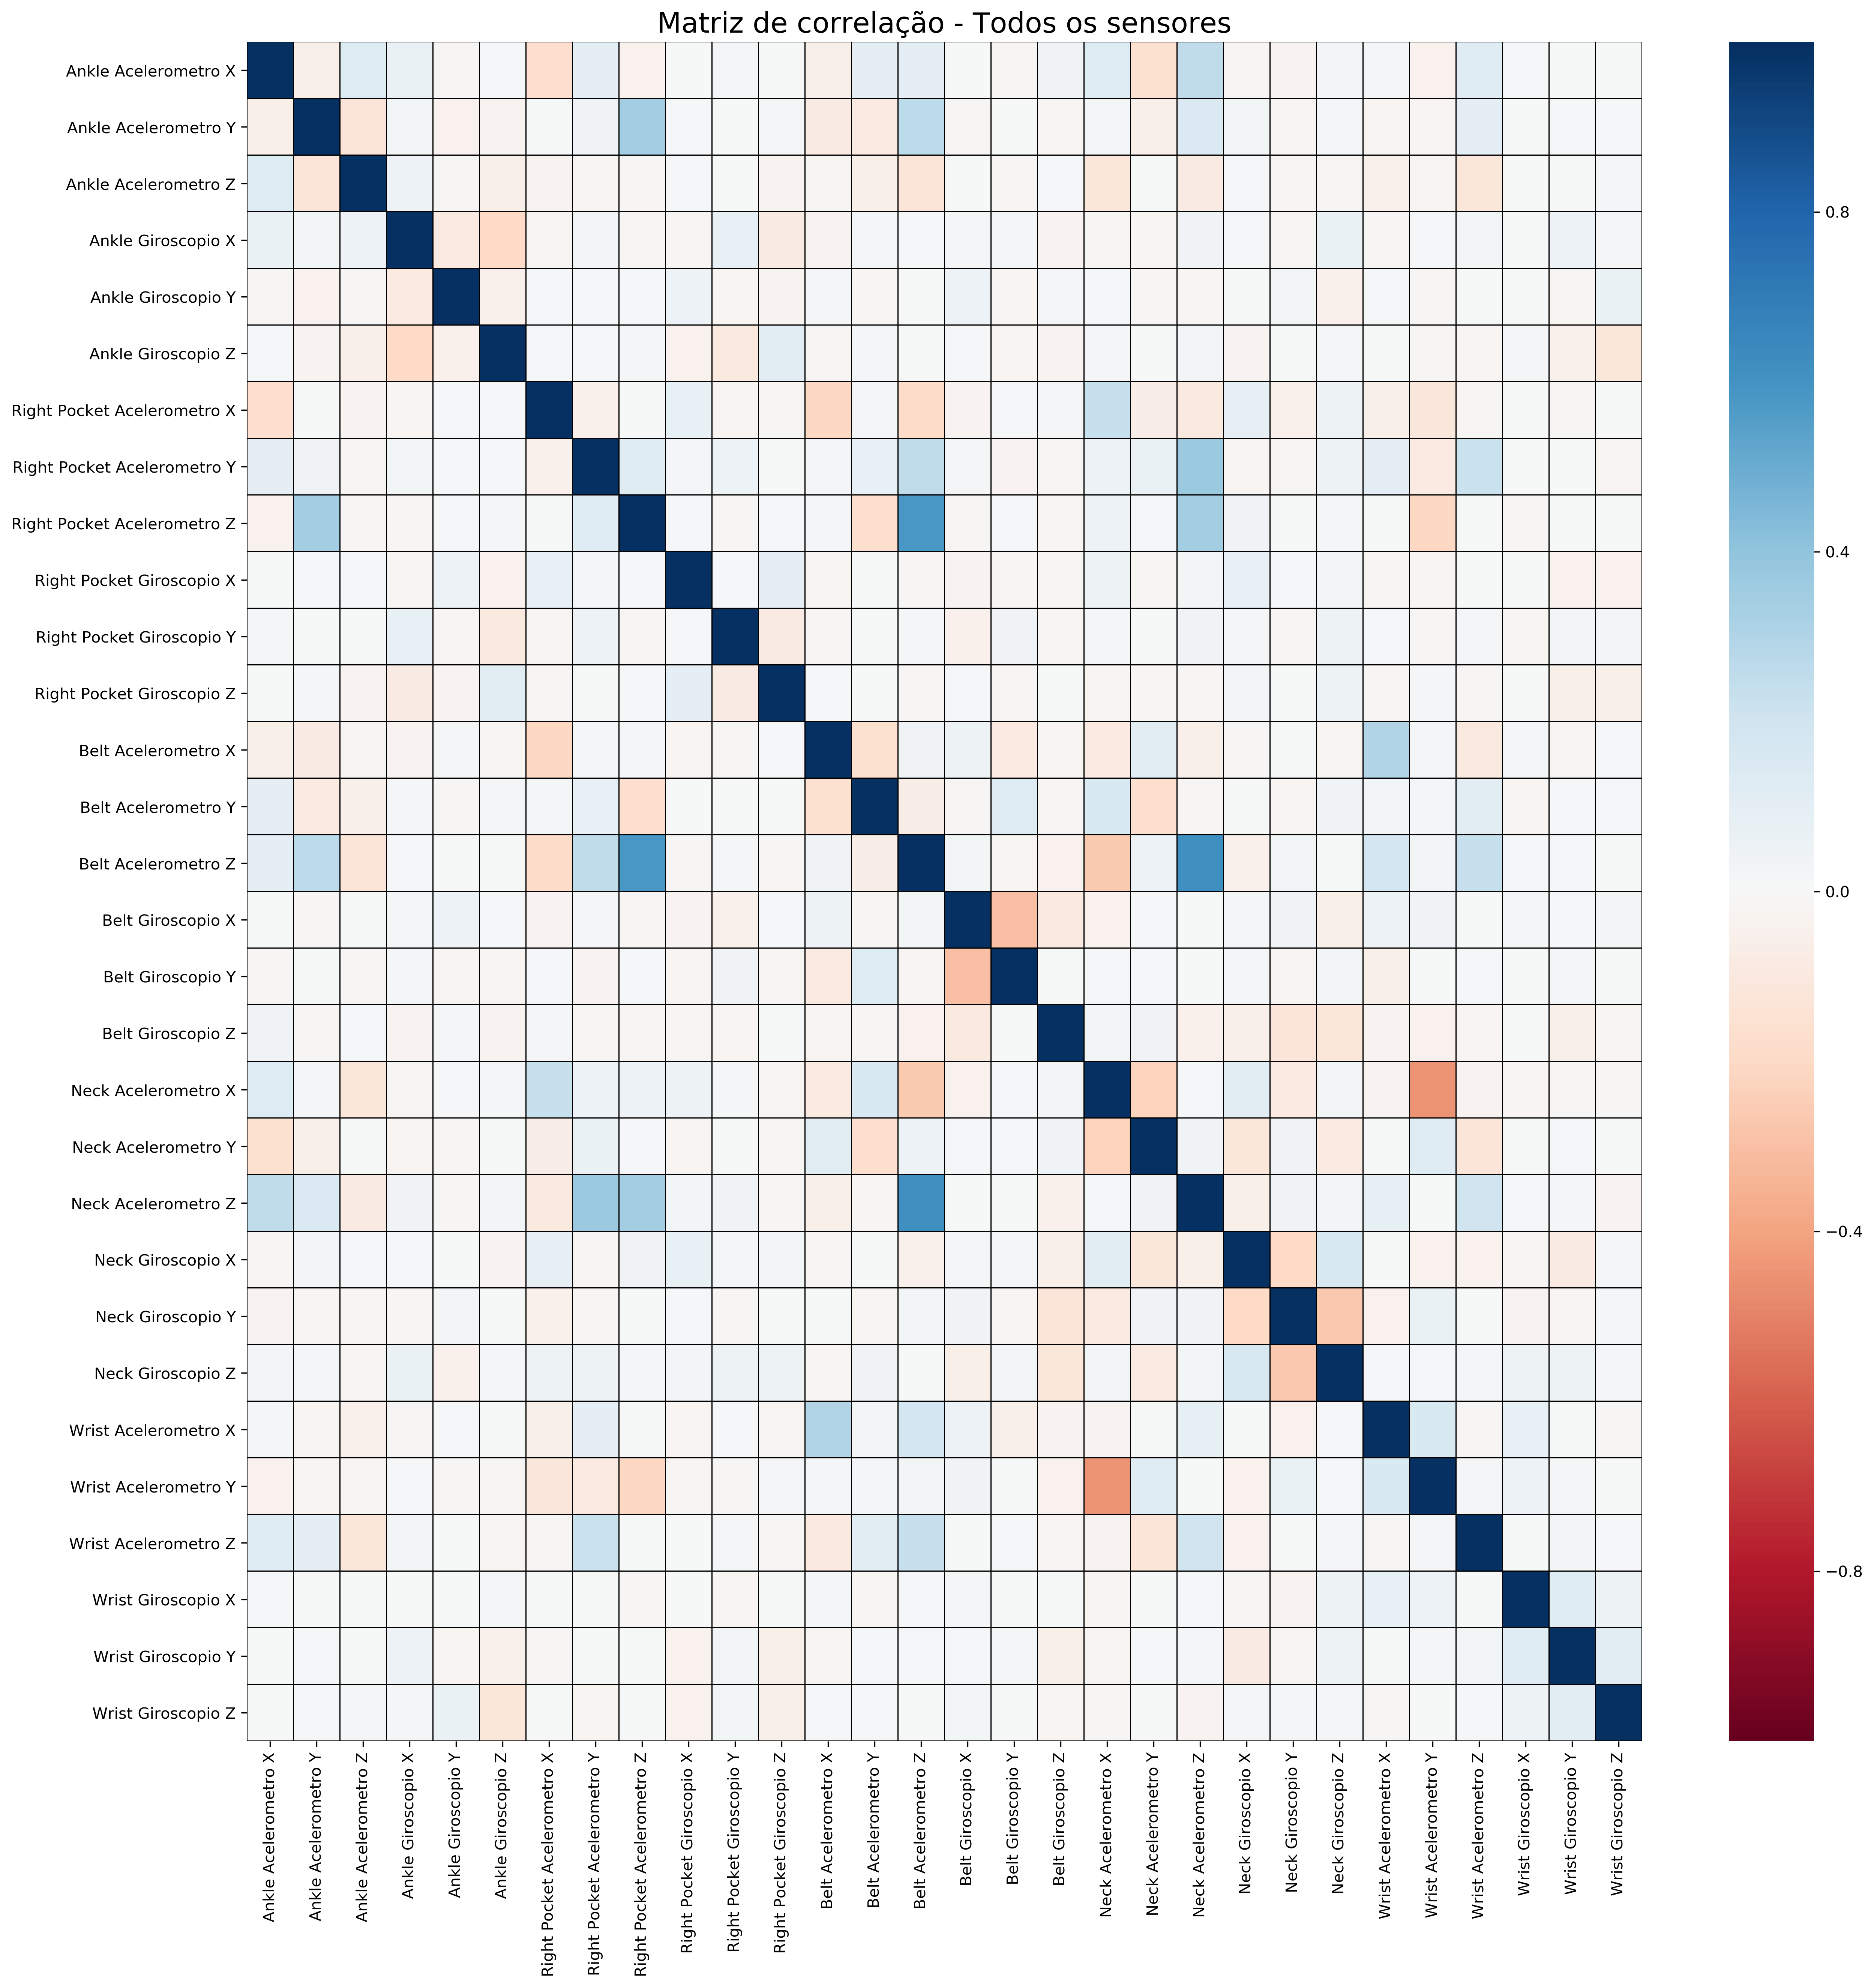

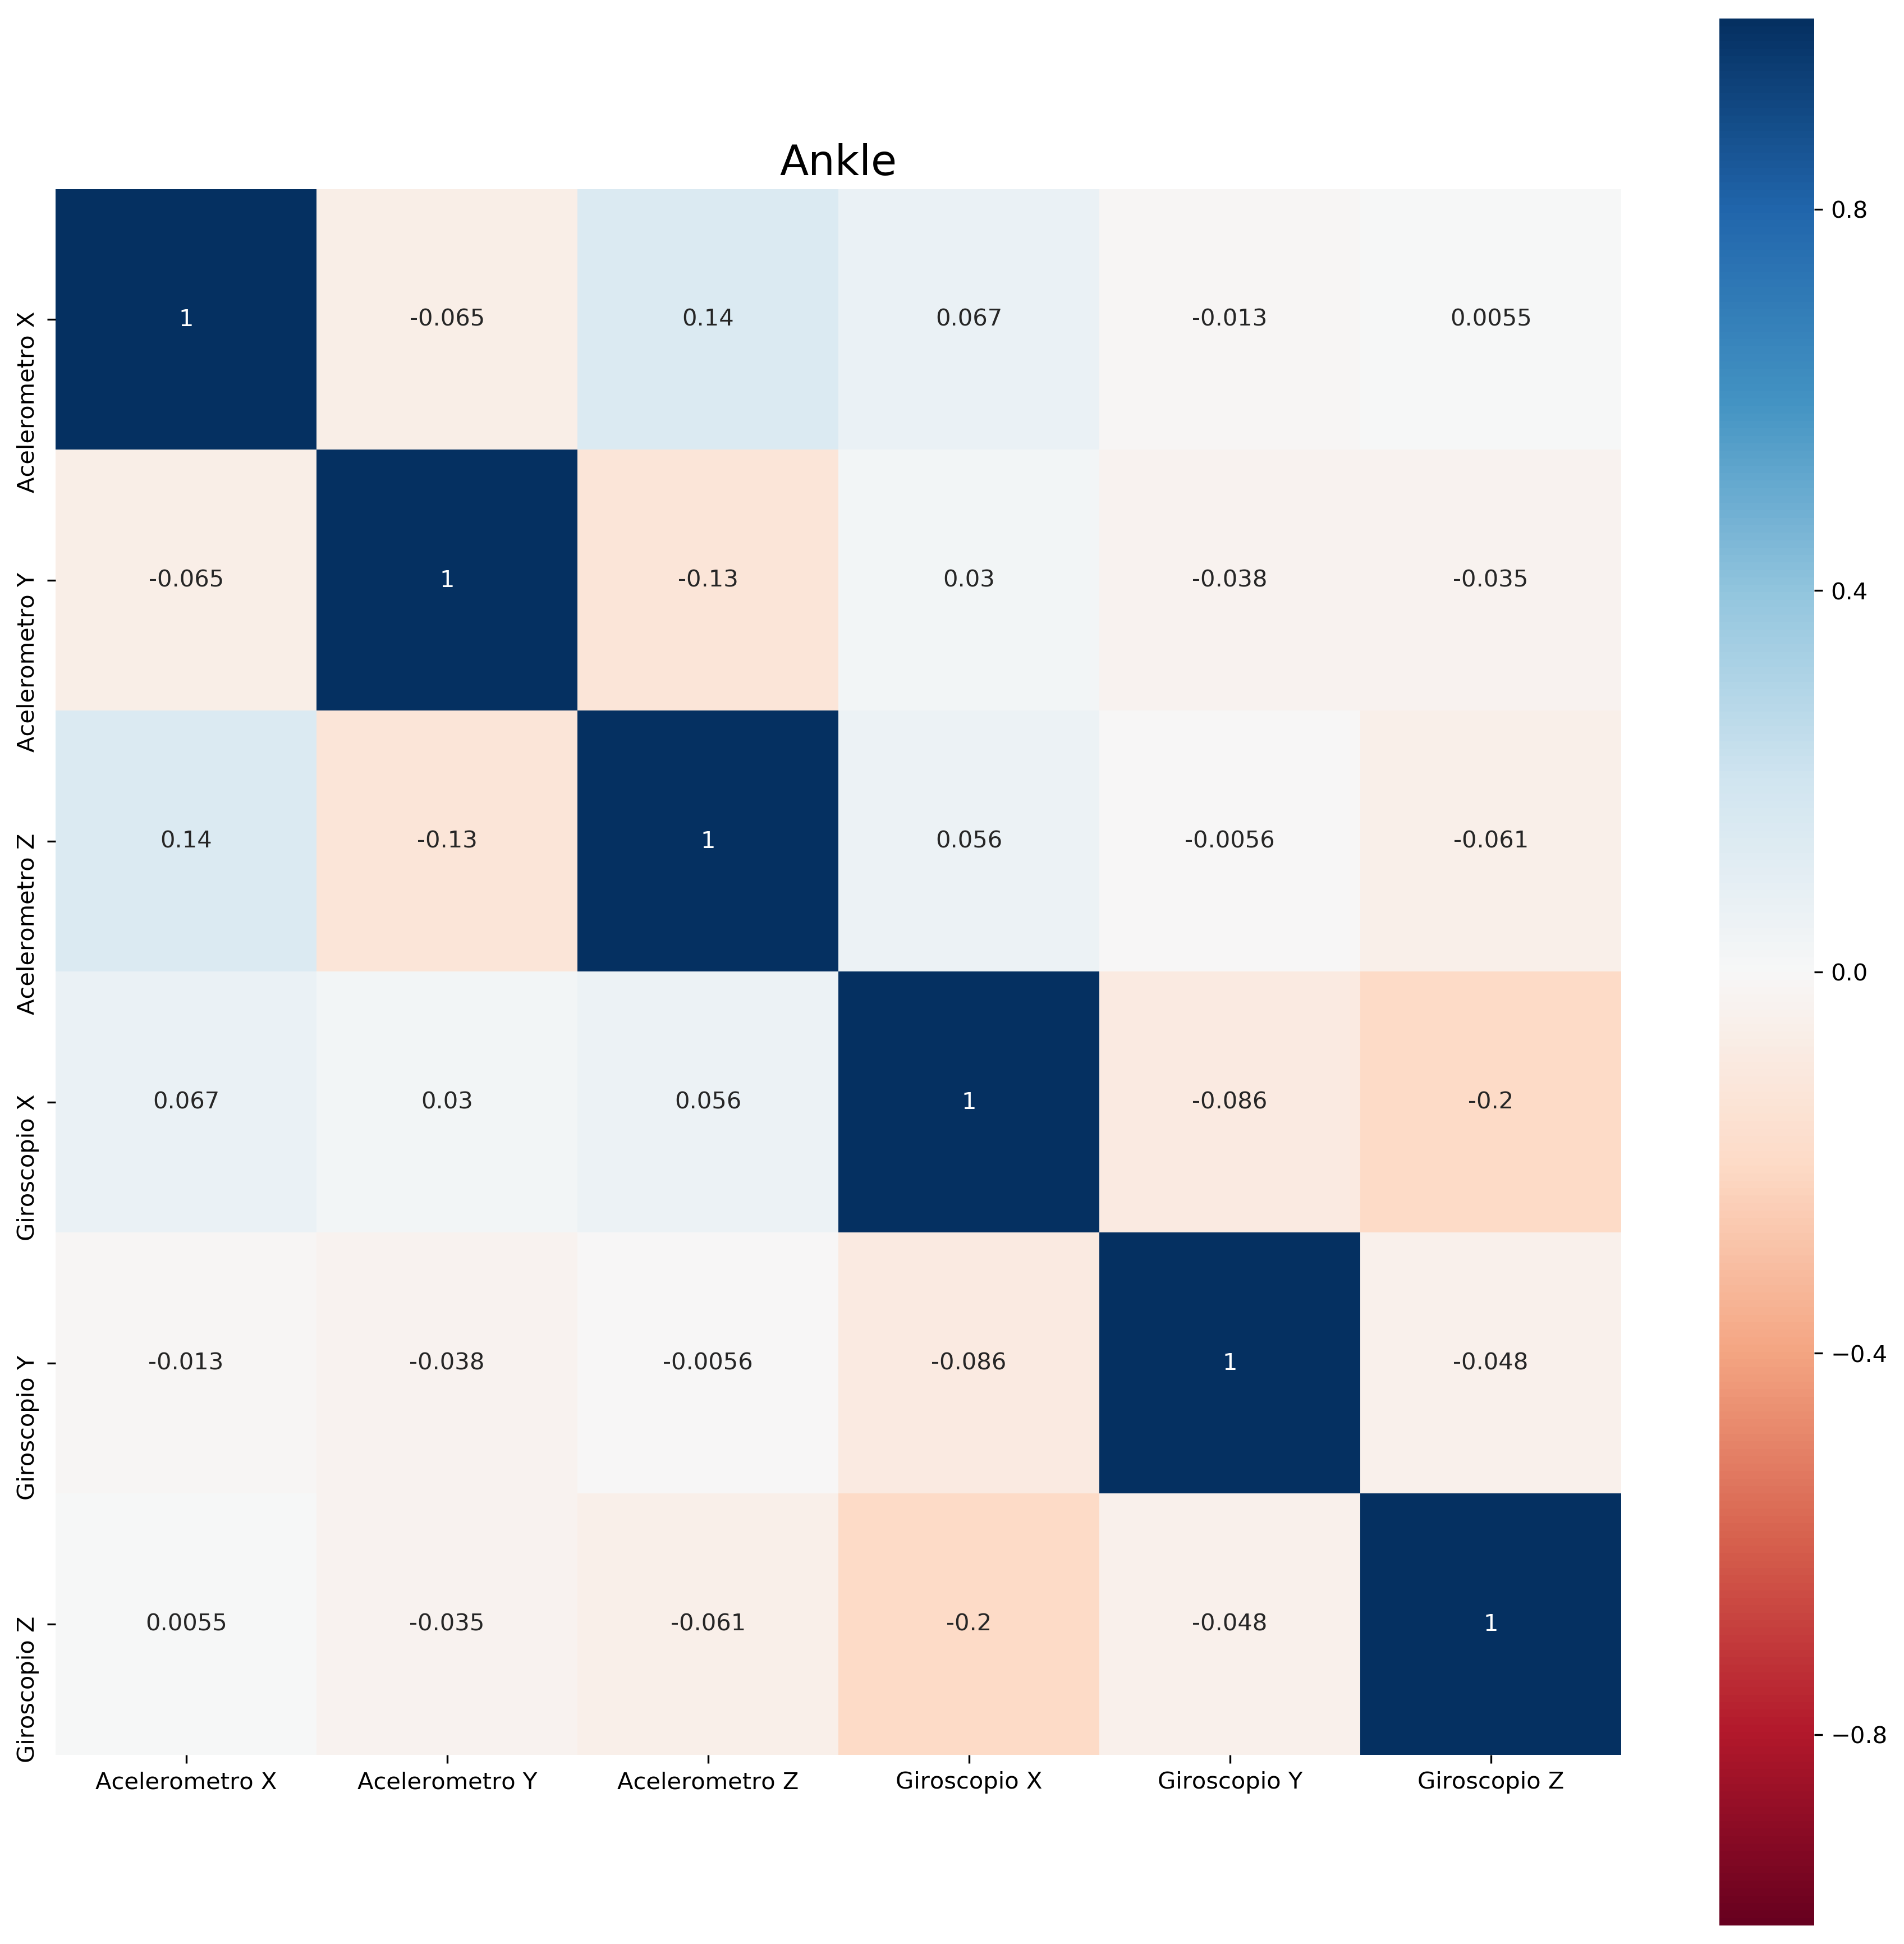

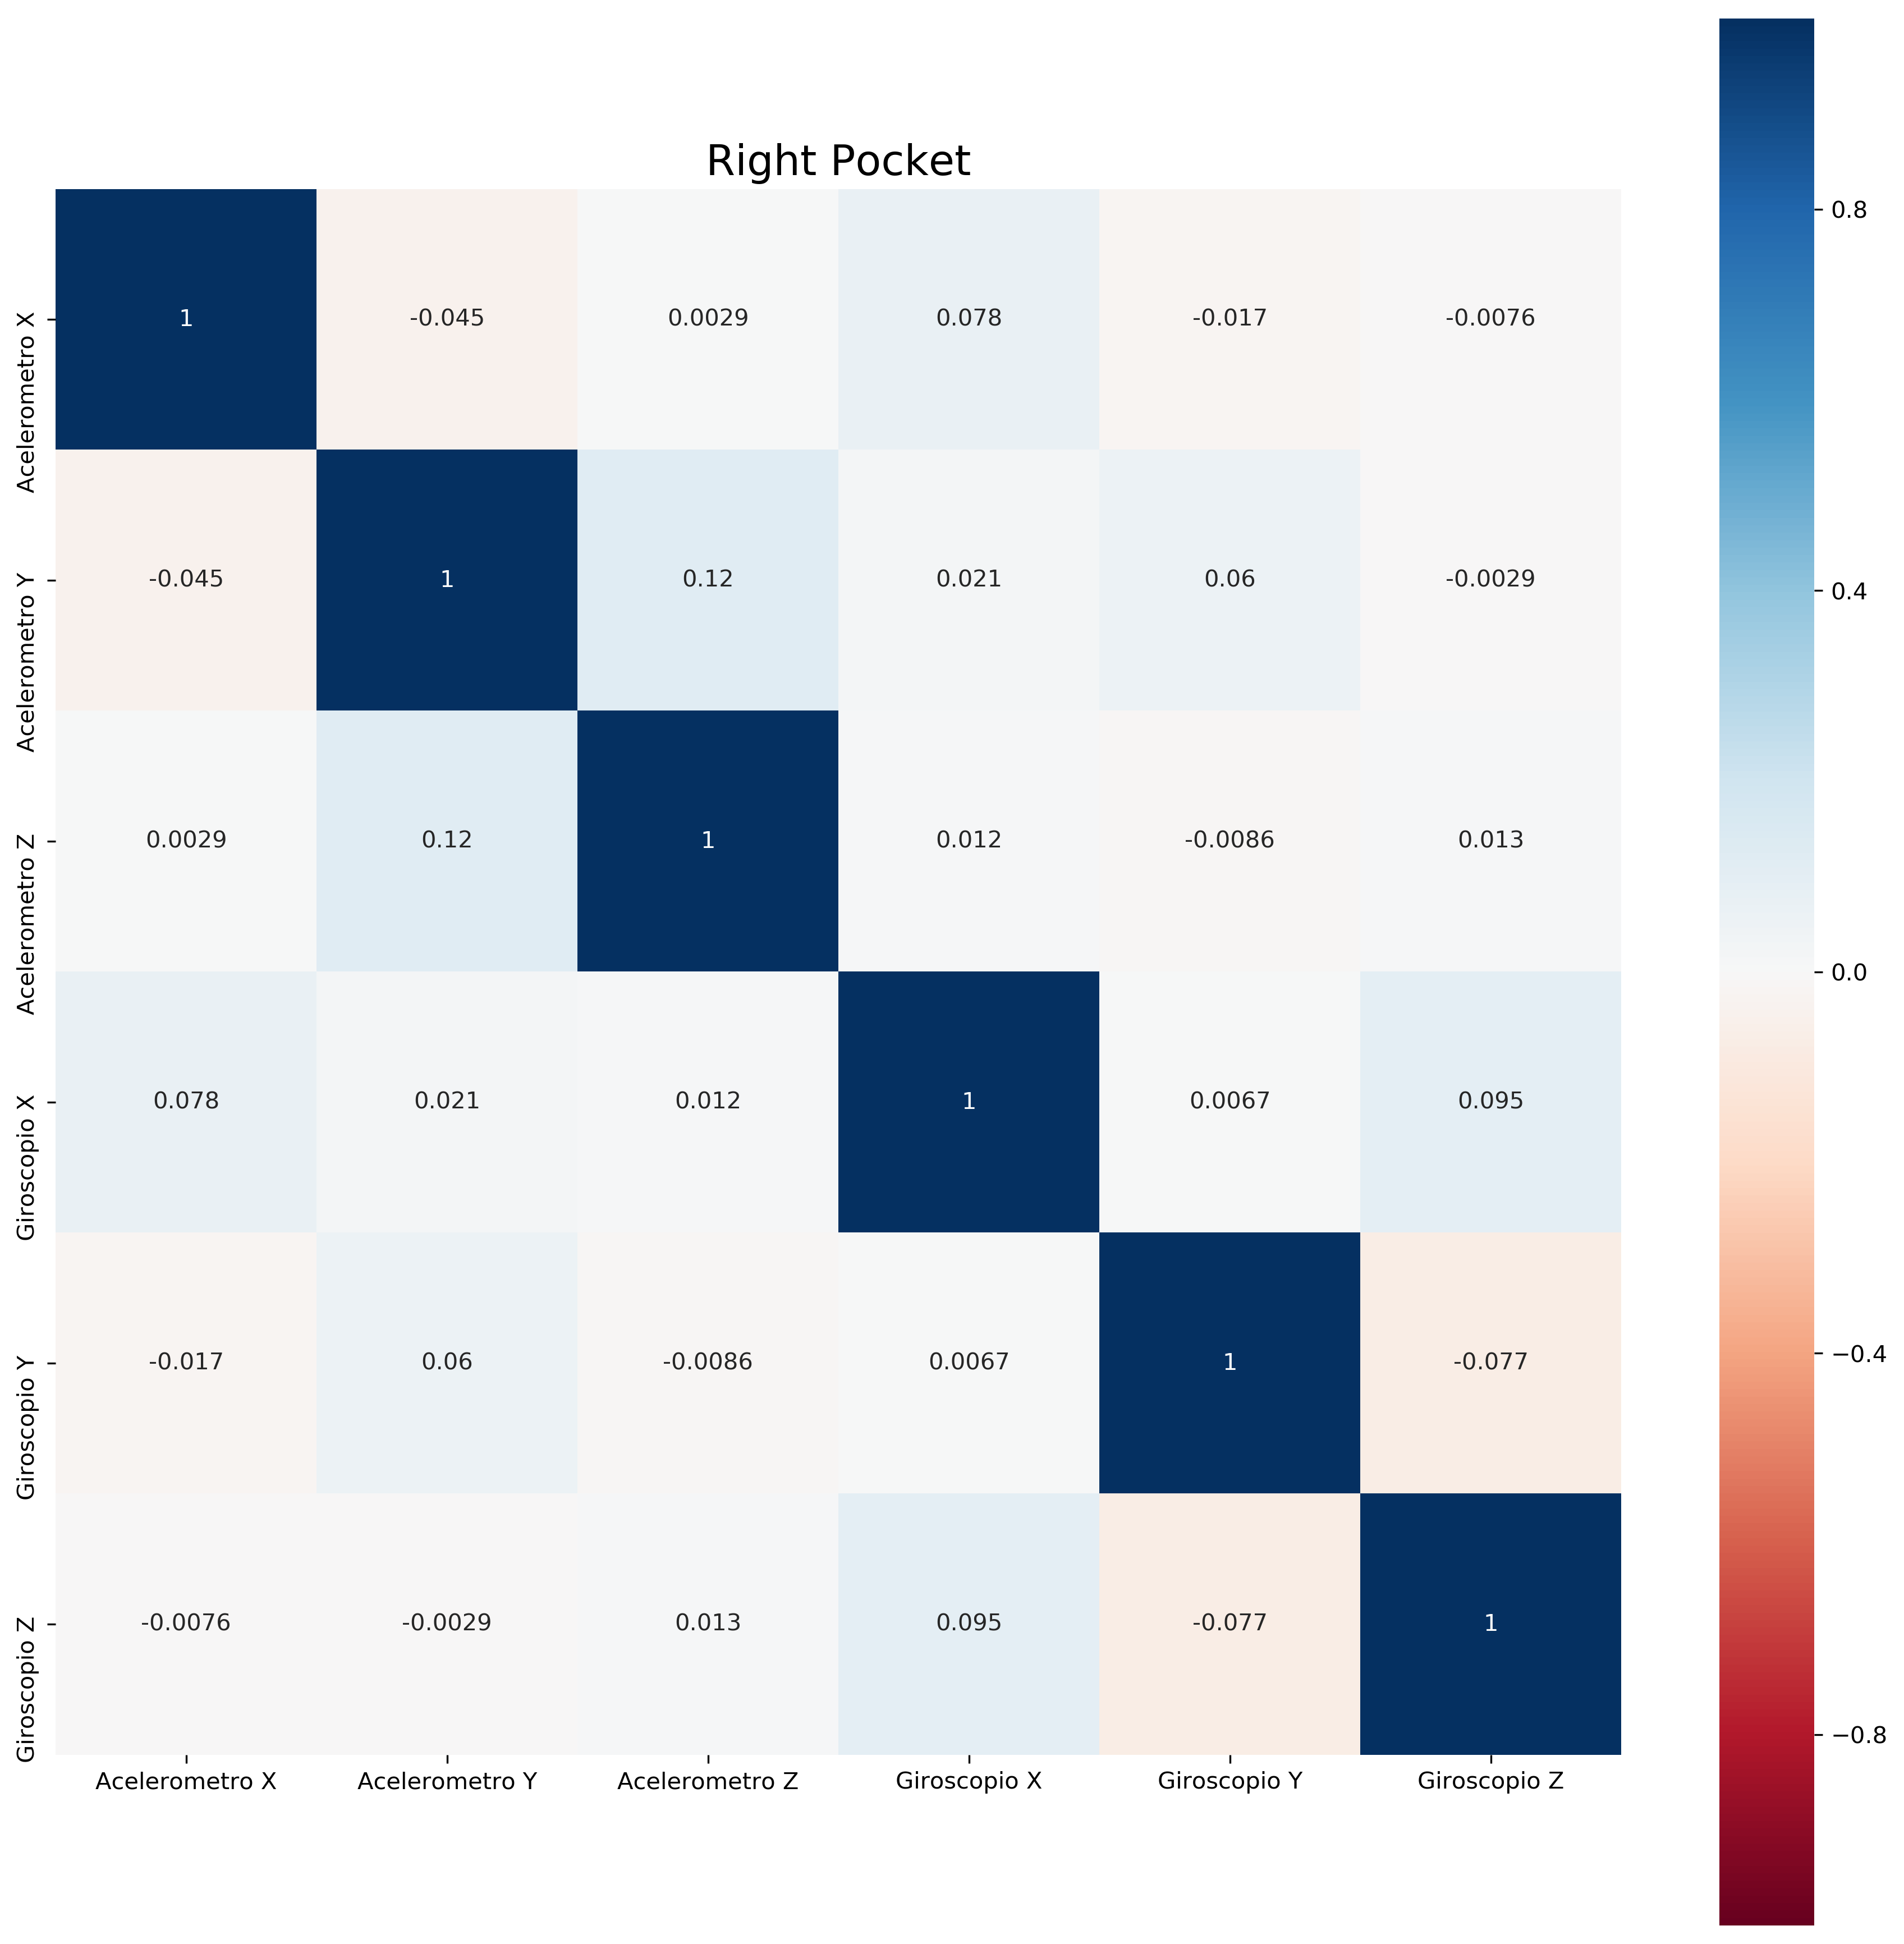

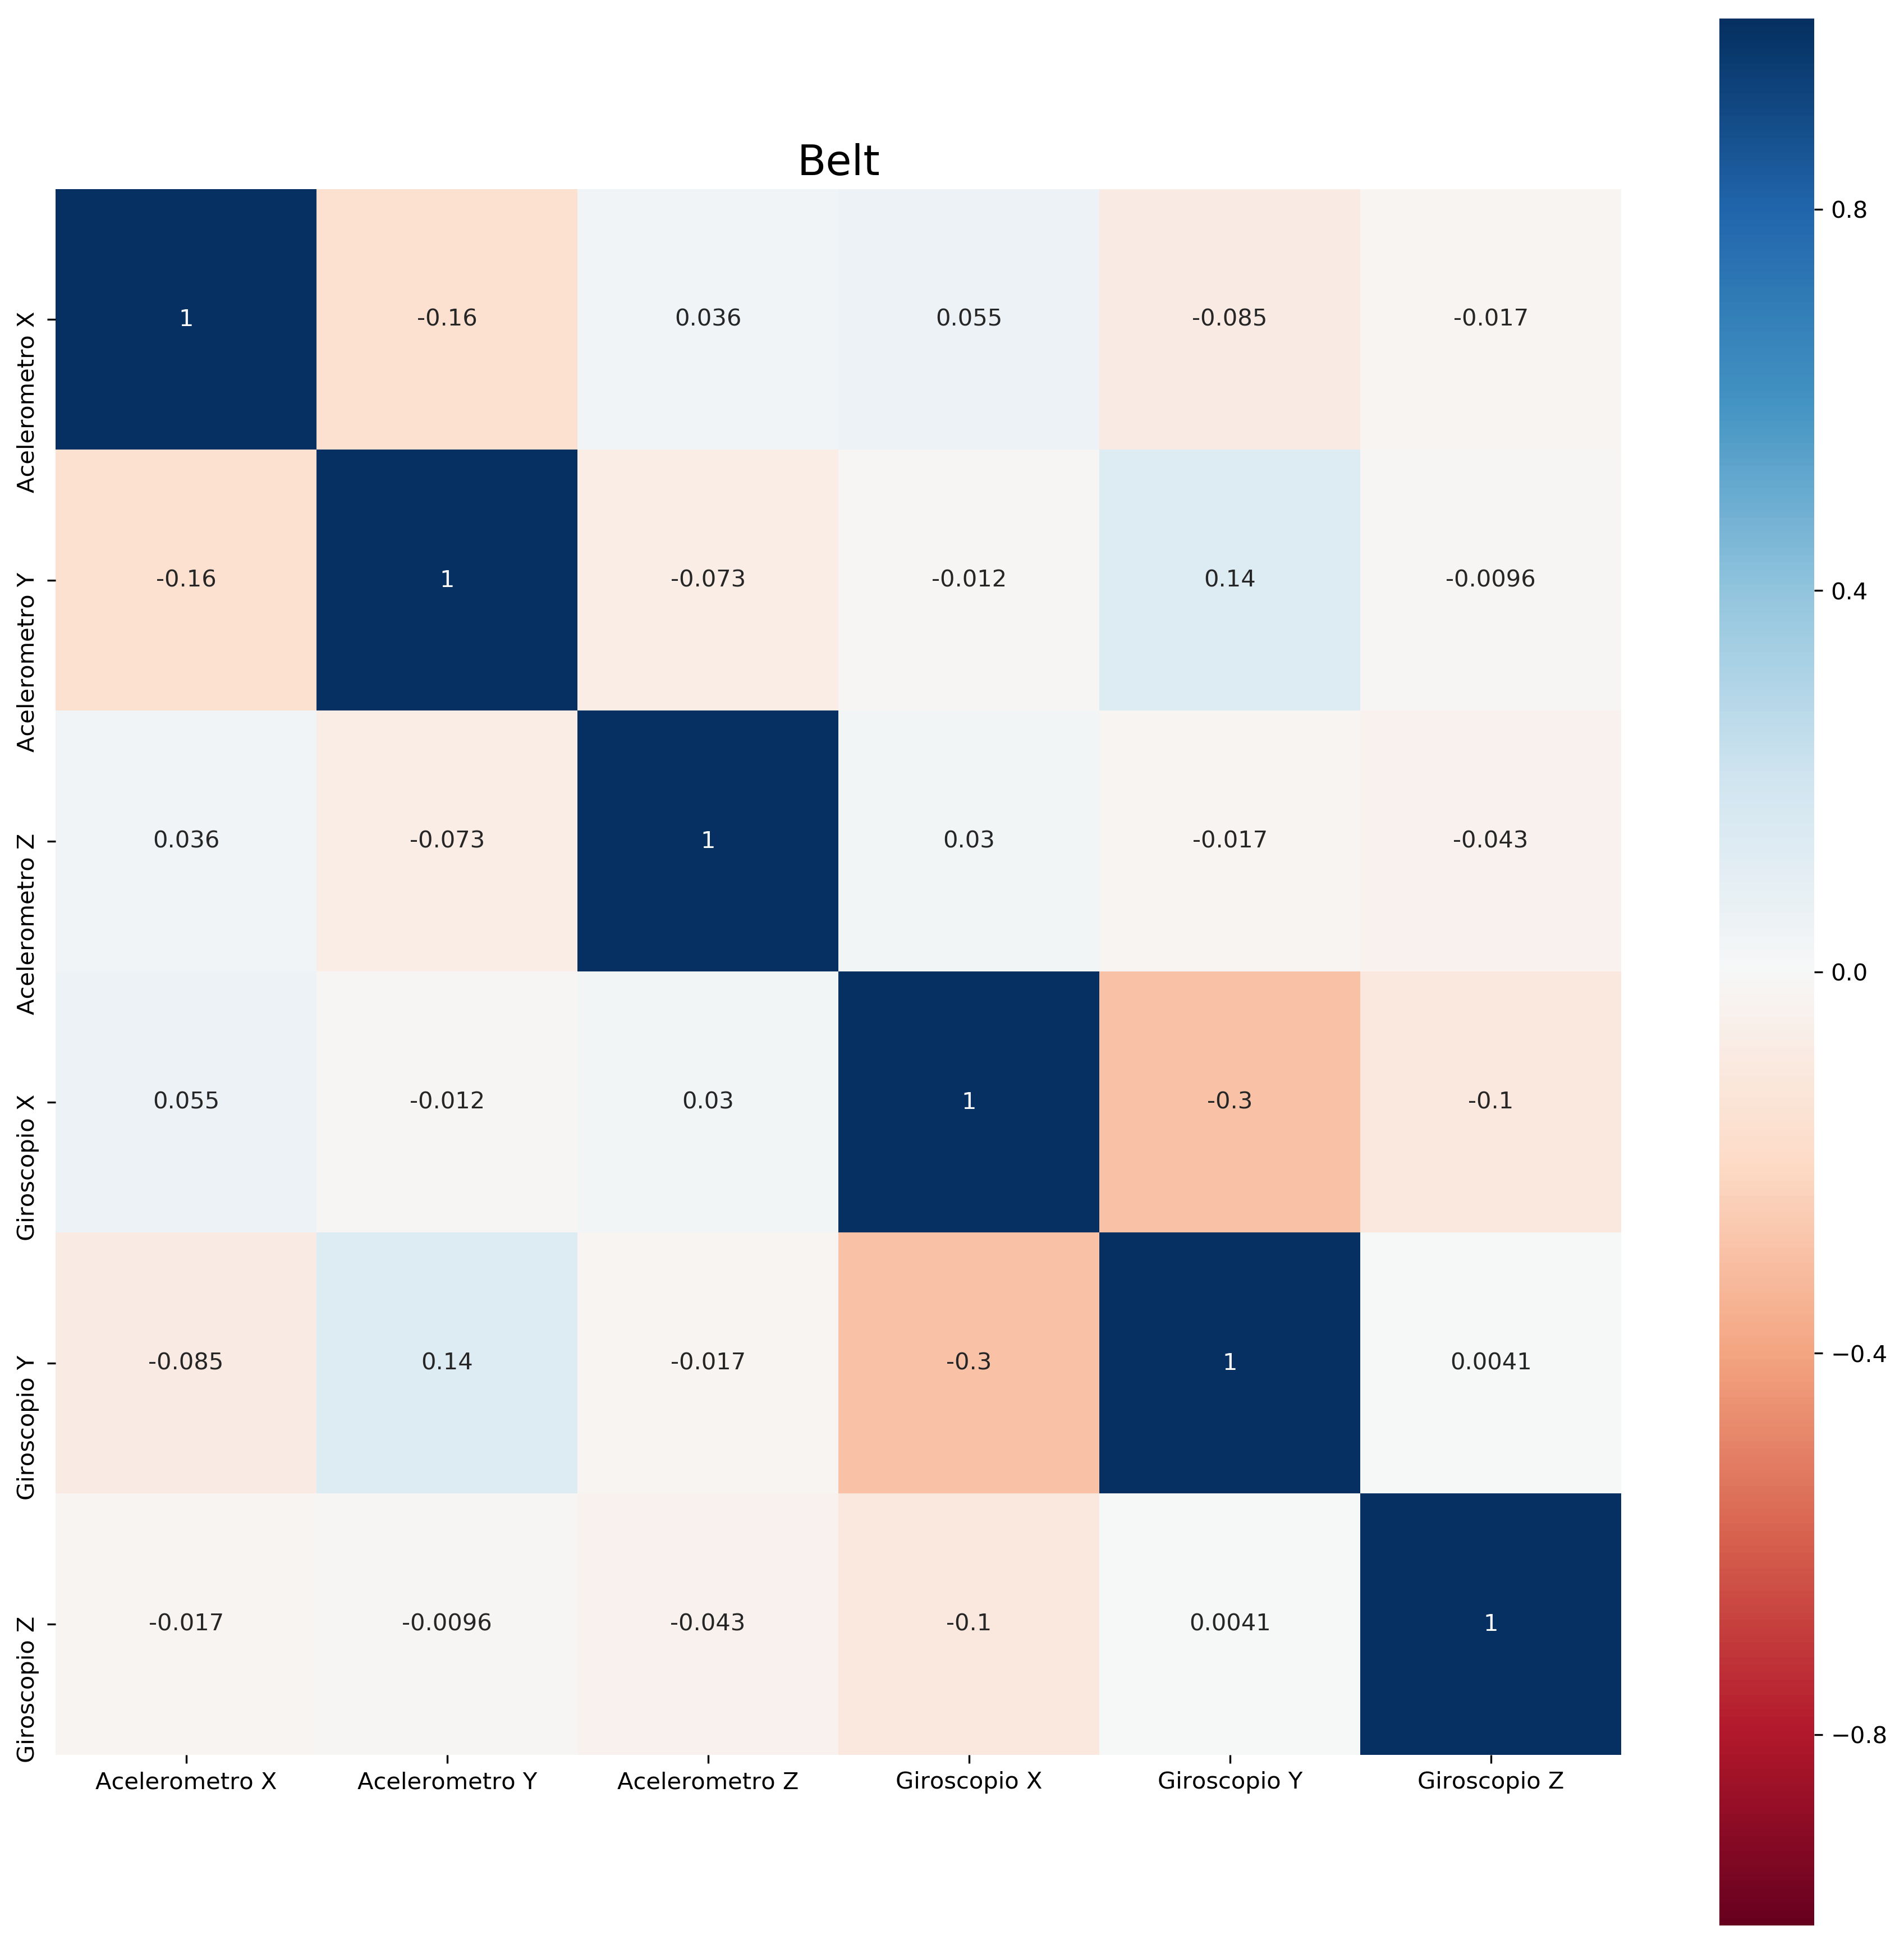

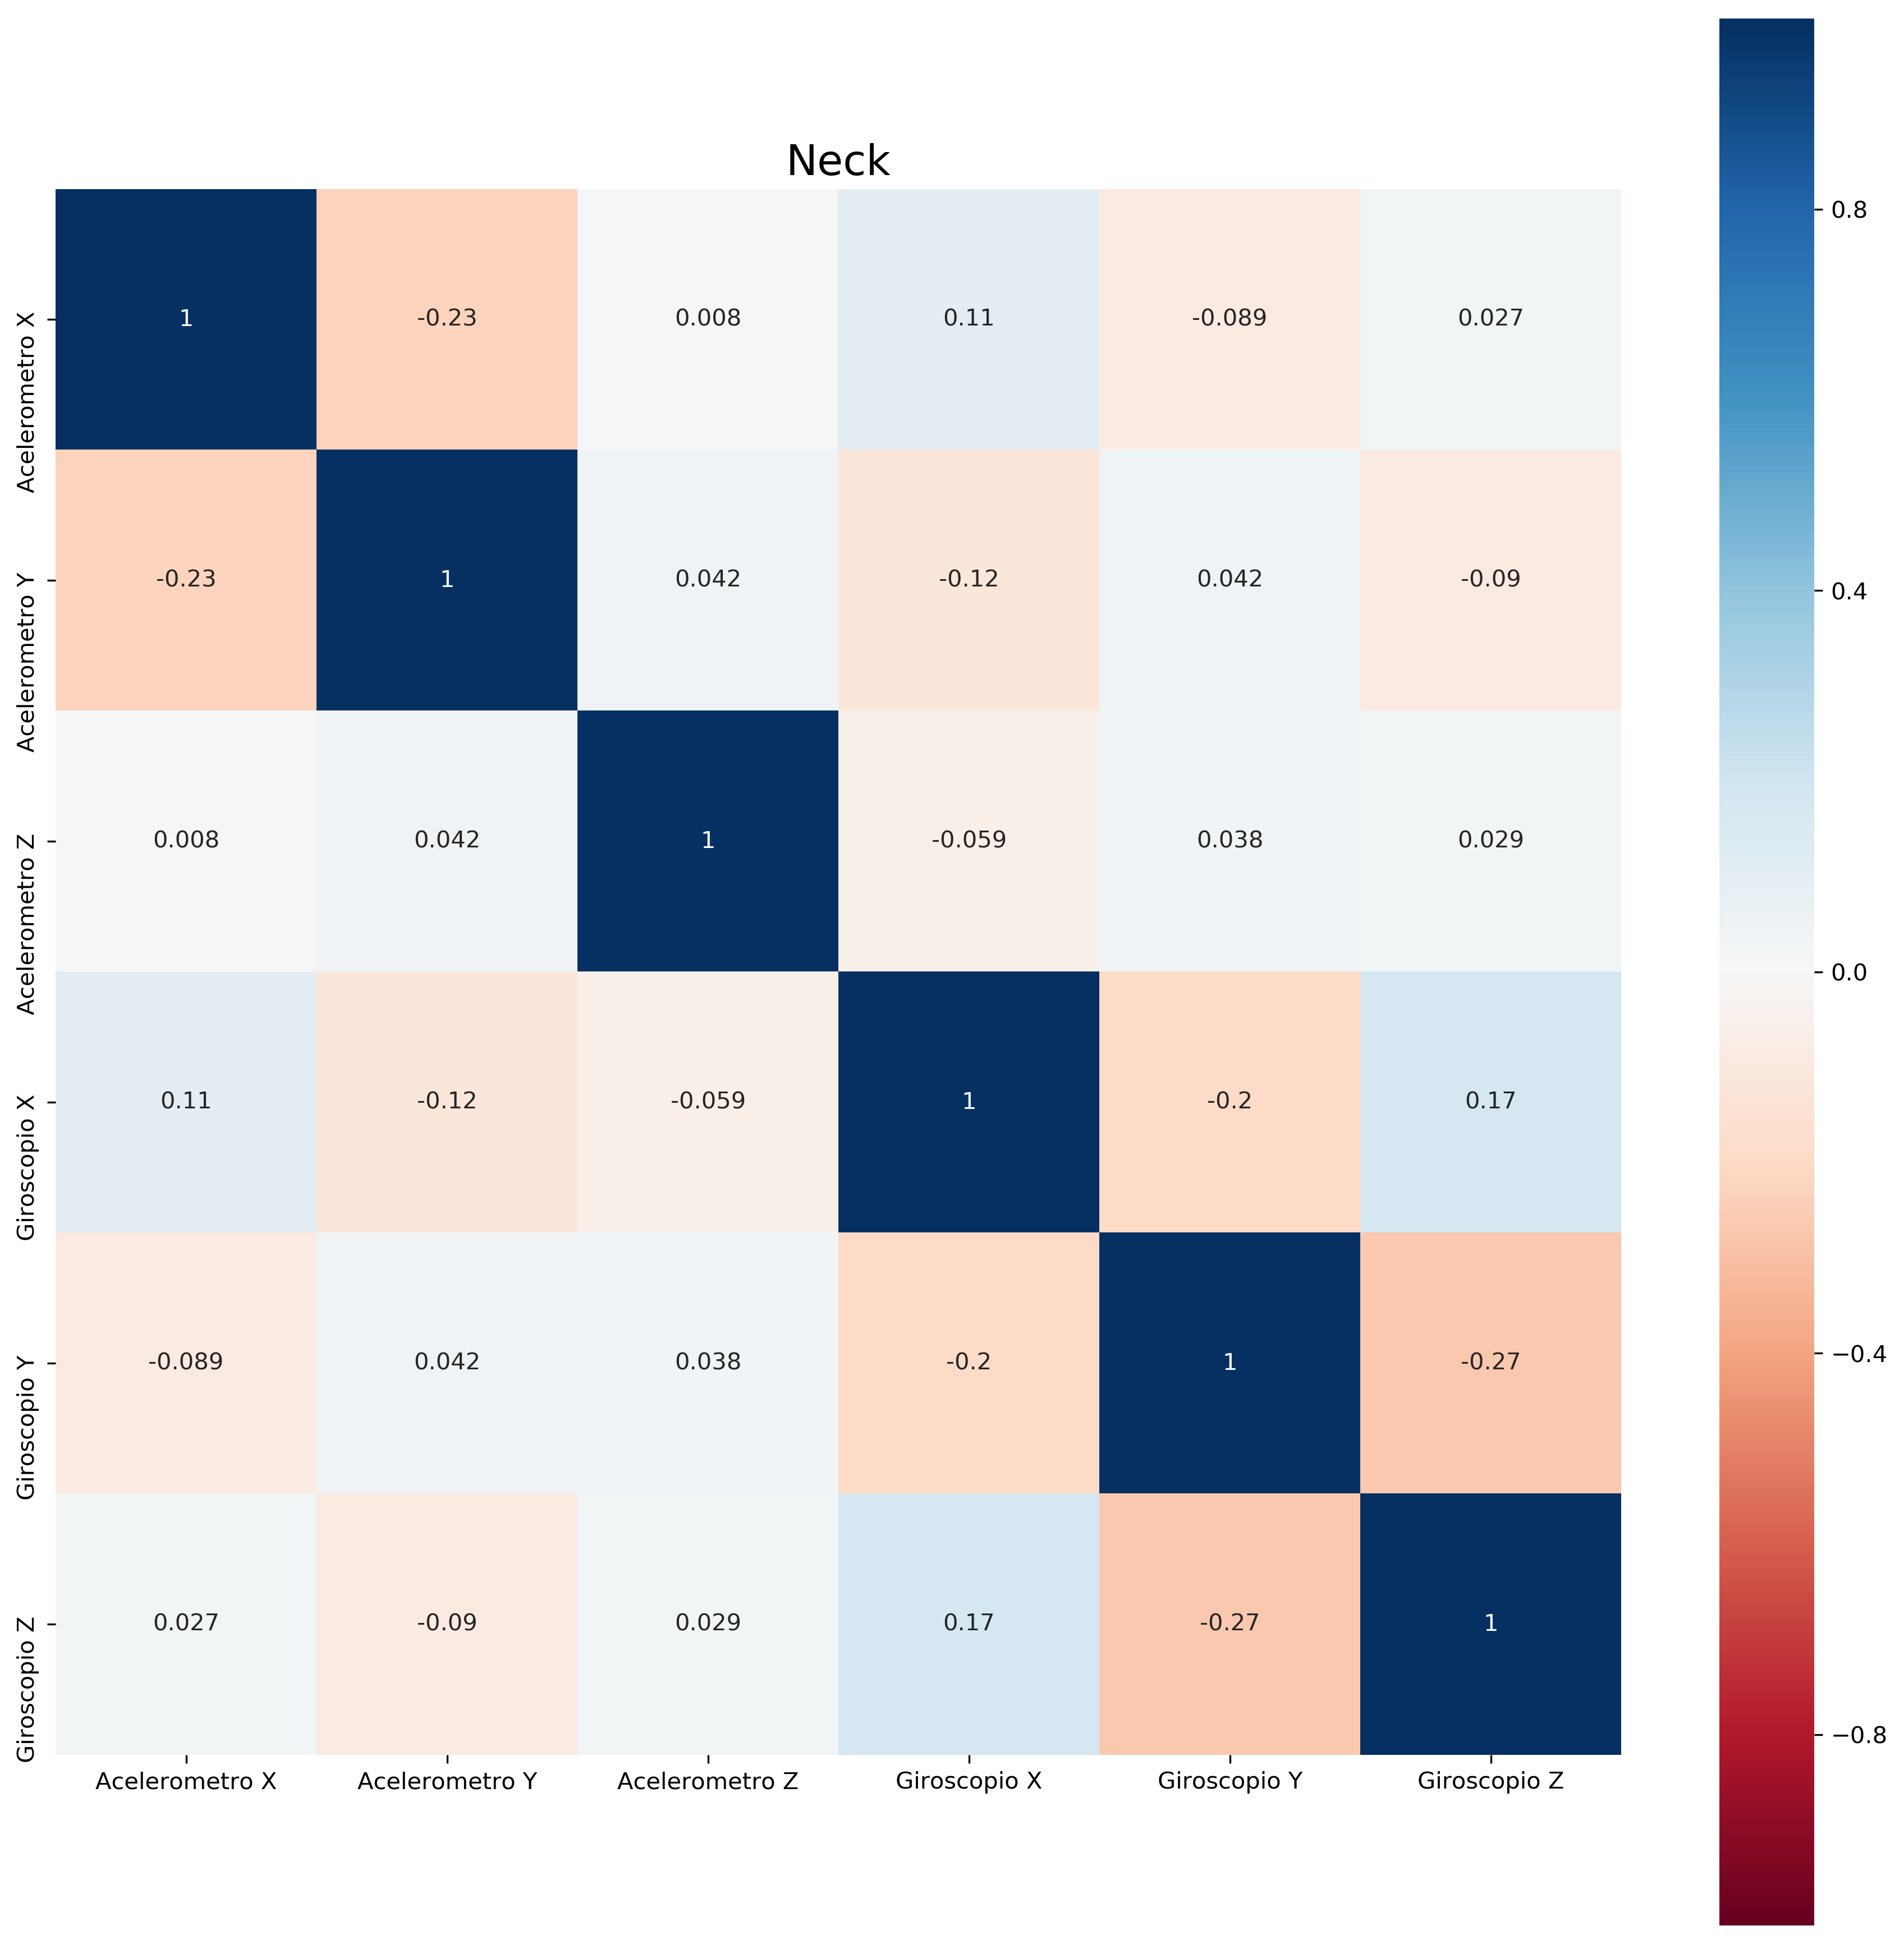

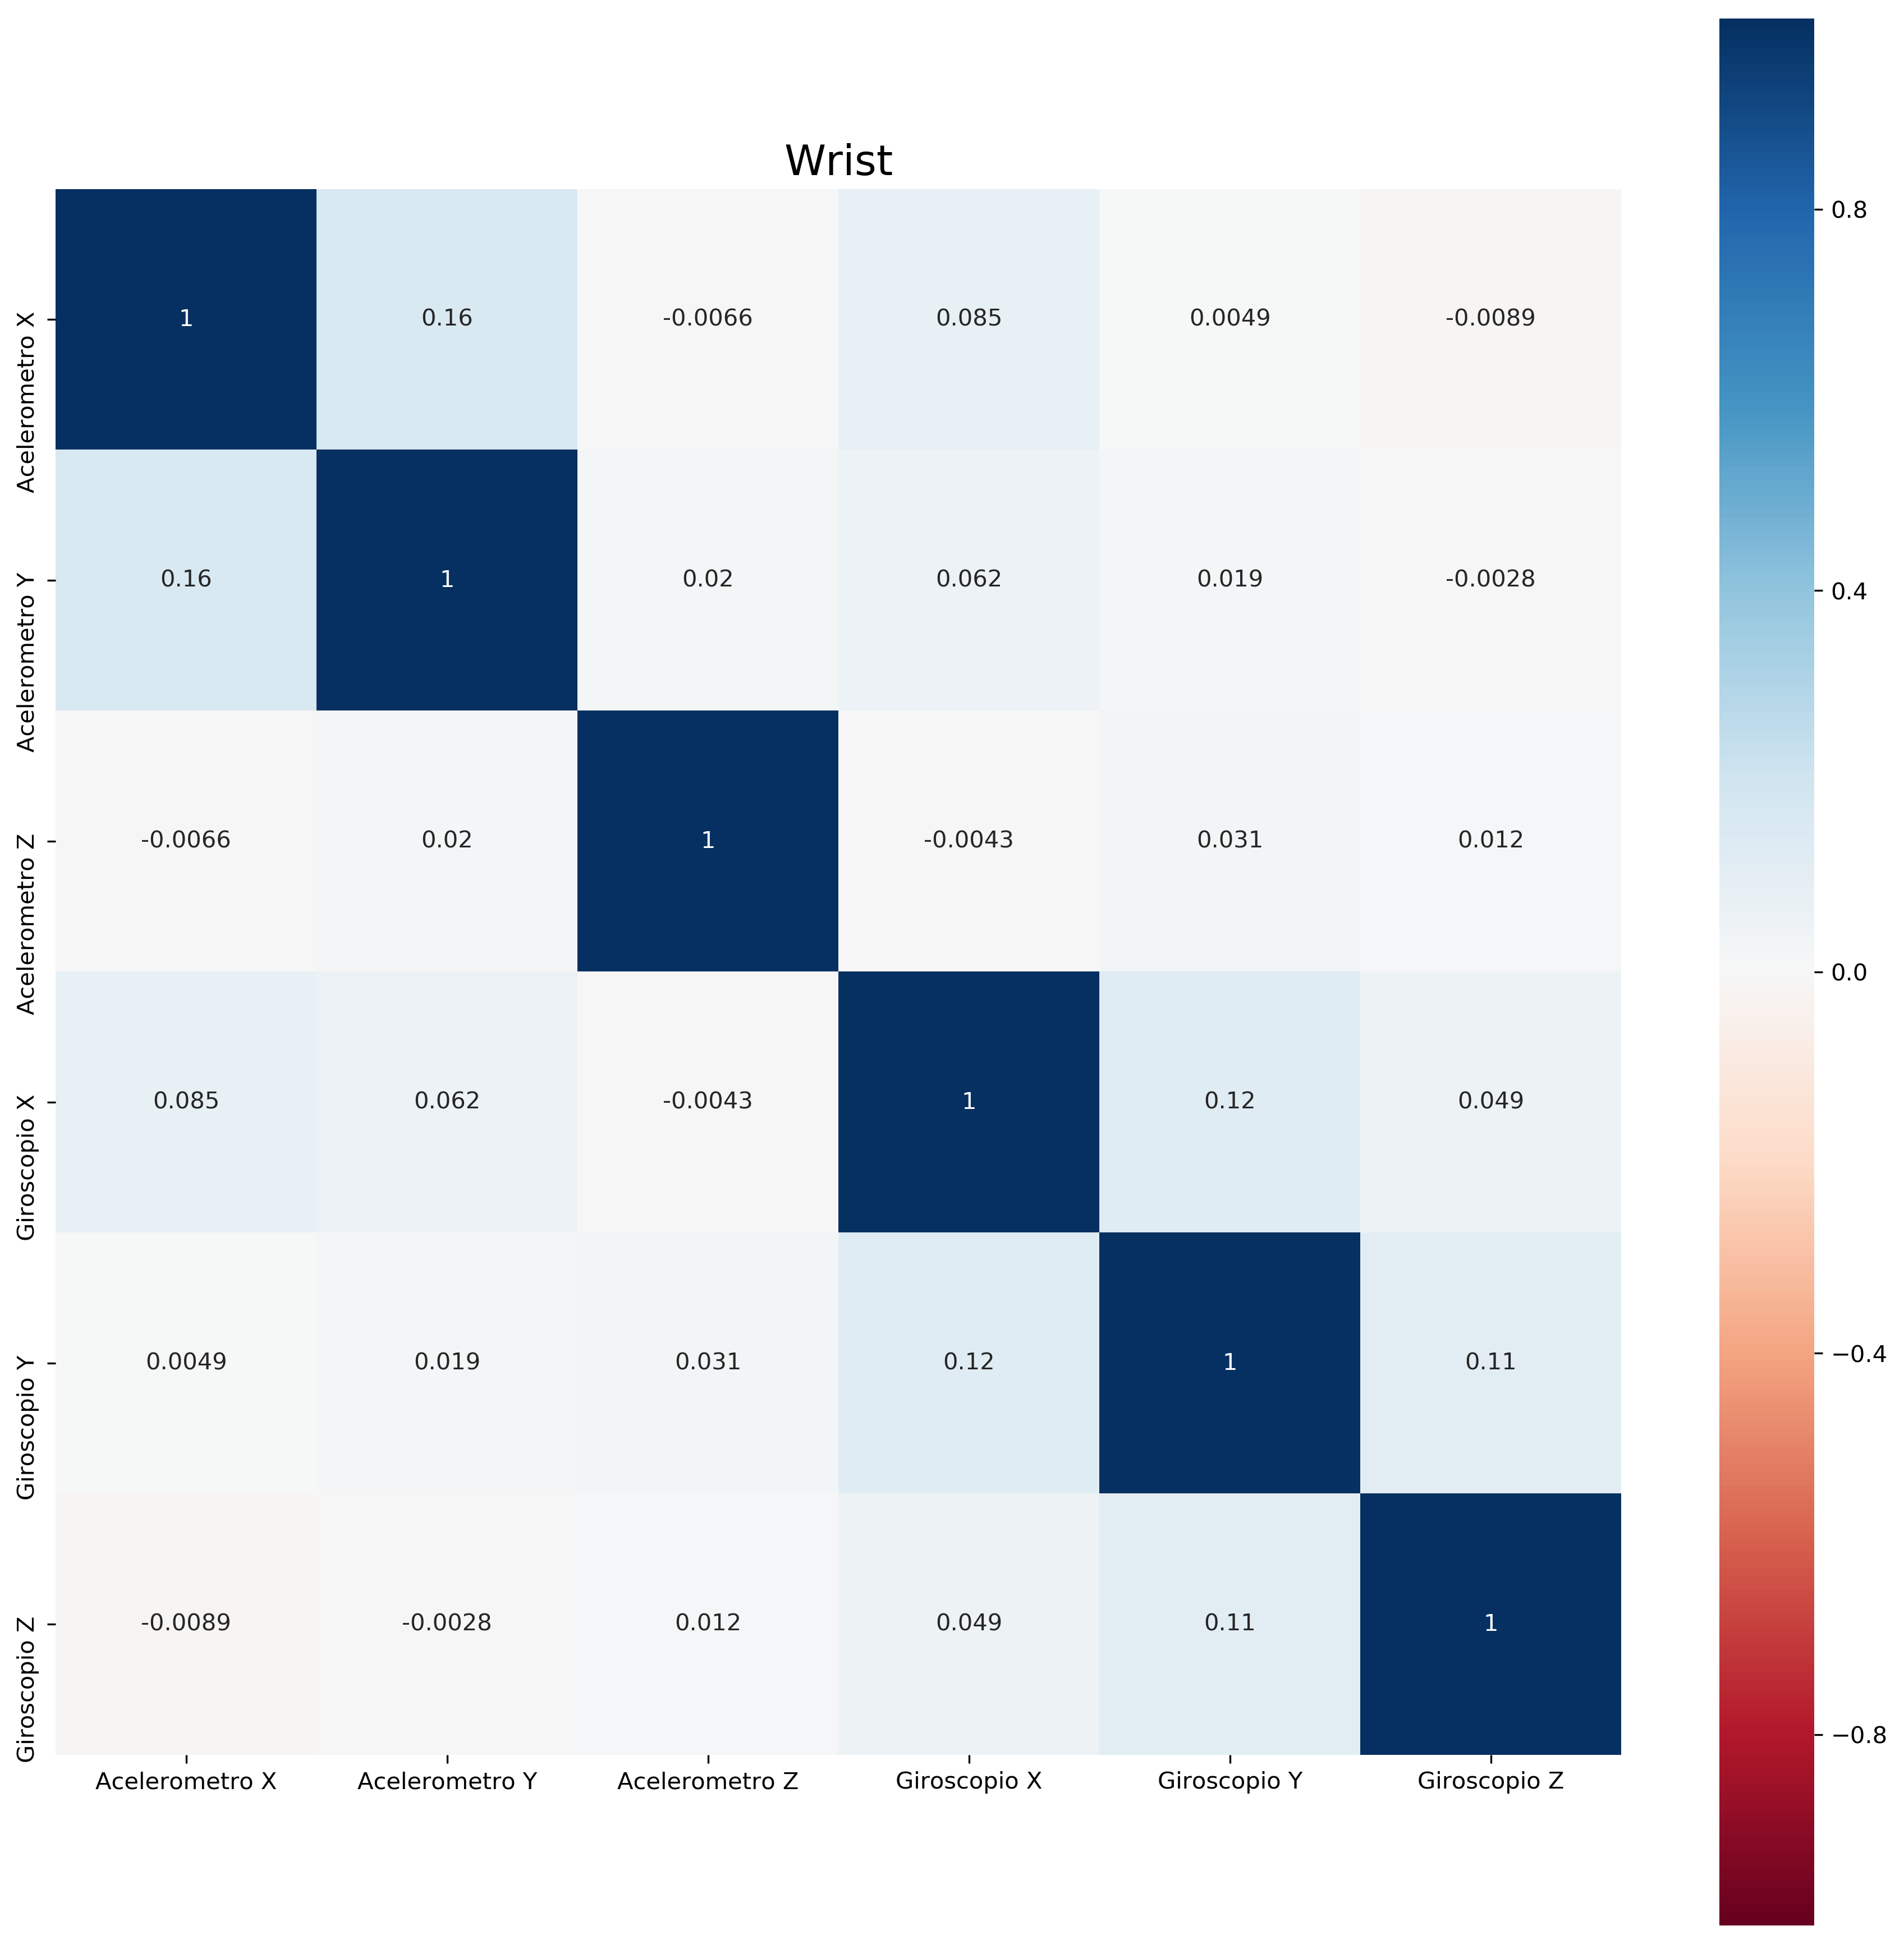

In [9]:
corr = total_data.corr()

plt.figure(dpi=300, figsize=(20, 20))
plt.title("Matriz de correlação - Todos os sensores", fontdict={'fontsize': 18})
sns.heatmap(corr.round(2), cmap="RdBu", xticklabels=sensors_features, yticklabels=sensors_features, vmin=-1, vmax=1,
            linecolor="black", linewidths=0.5)
# plt.xticks(rotation=45)
# plt.yticks(rotation=45)
# plt.savefig("total_data.png", dpi=300, format="png")

plt.show()

for sensor in sensors:
    corr = sensors[sensor].corr()

    plt.figure(dpi=300, figsize=(15, 15))
    plt.title(sensor, fontdict={'fontsize': 18})
    sns.heatmap(corr, cmap="RdBu", vmin=-1, vmax=1, xticklabels=features, yticklabels=features, annot=True, square=True)
    # plt.savefig(sensor + ".png", dpi=300)
    plt.show()

# Função para reportar as melhores pontuações do modelo

In [18]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                results['mean_test_score'][candidate],
                results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")





# Treinamento utilizando o Random Forest

* Utiliza cross-validation
* 30% dos dados são usados para teste e 70% para o treinamento

GridSearchCV for Ankle data using Random Forest took 17.14 seconds for 1 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.894 (std: 0.001)
Parameters: {'bootstrap': True, 'min_samples_split': 2, 'n_estimators': 10}

Acuracia: 0.8977206689481501
Random Forest clf_report (output_dict=False)
                                precision    recall  f1-score   support

   Falling forward using hands       0.78      0.69      0.73      2472
   Falling forward using knees       0.81      0.73      0.77      2441
             Falling backwards       0.81      0.69      0.75      2448
              Falling sideward       0.85      0.81      0.83      2454
Falling sitting in empty chair       0.84      0.68      0.75      2317
                       Walking       0.86      0.95      0.90     14204
                      Standing       0.91      0.96      0.93     14104
                       Sitting       0.94      0.94      0.94     14182
          Picking up an object      

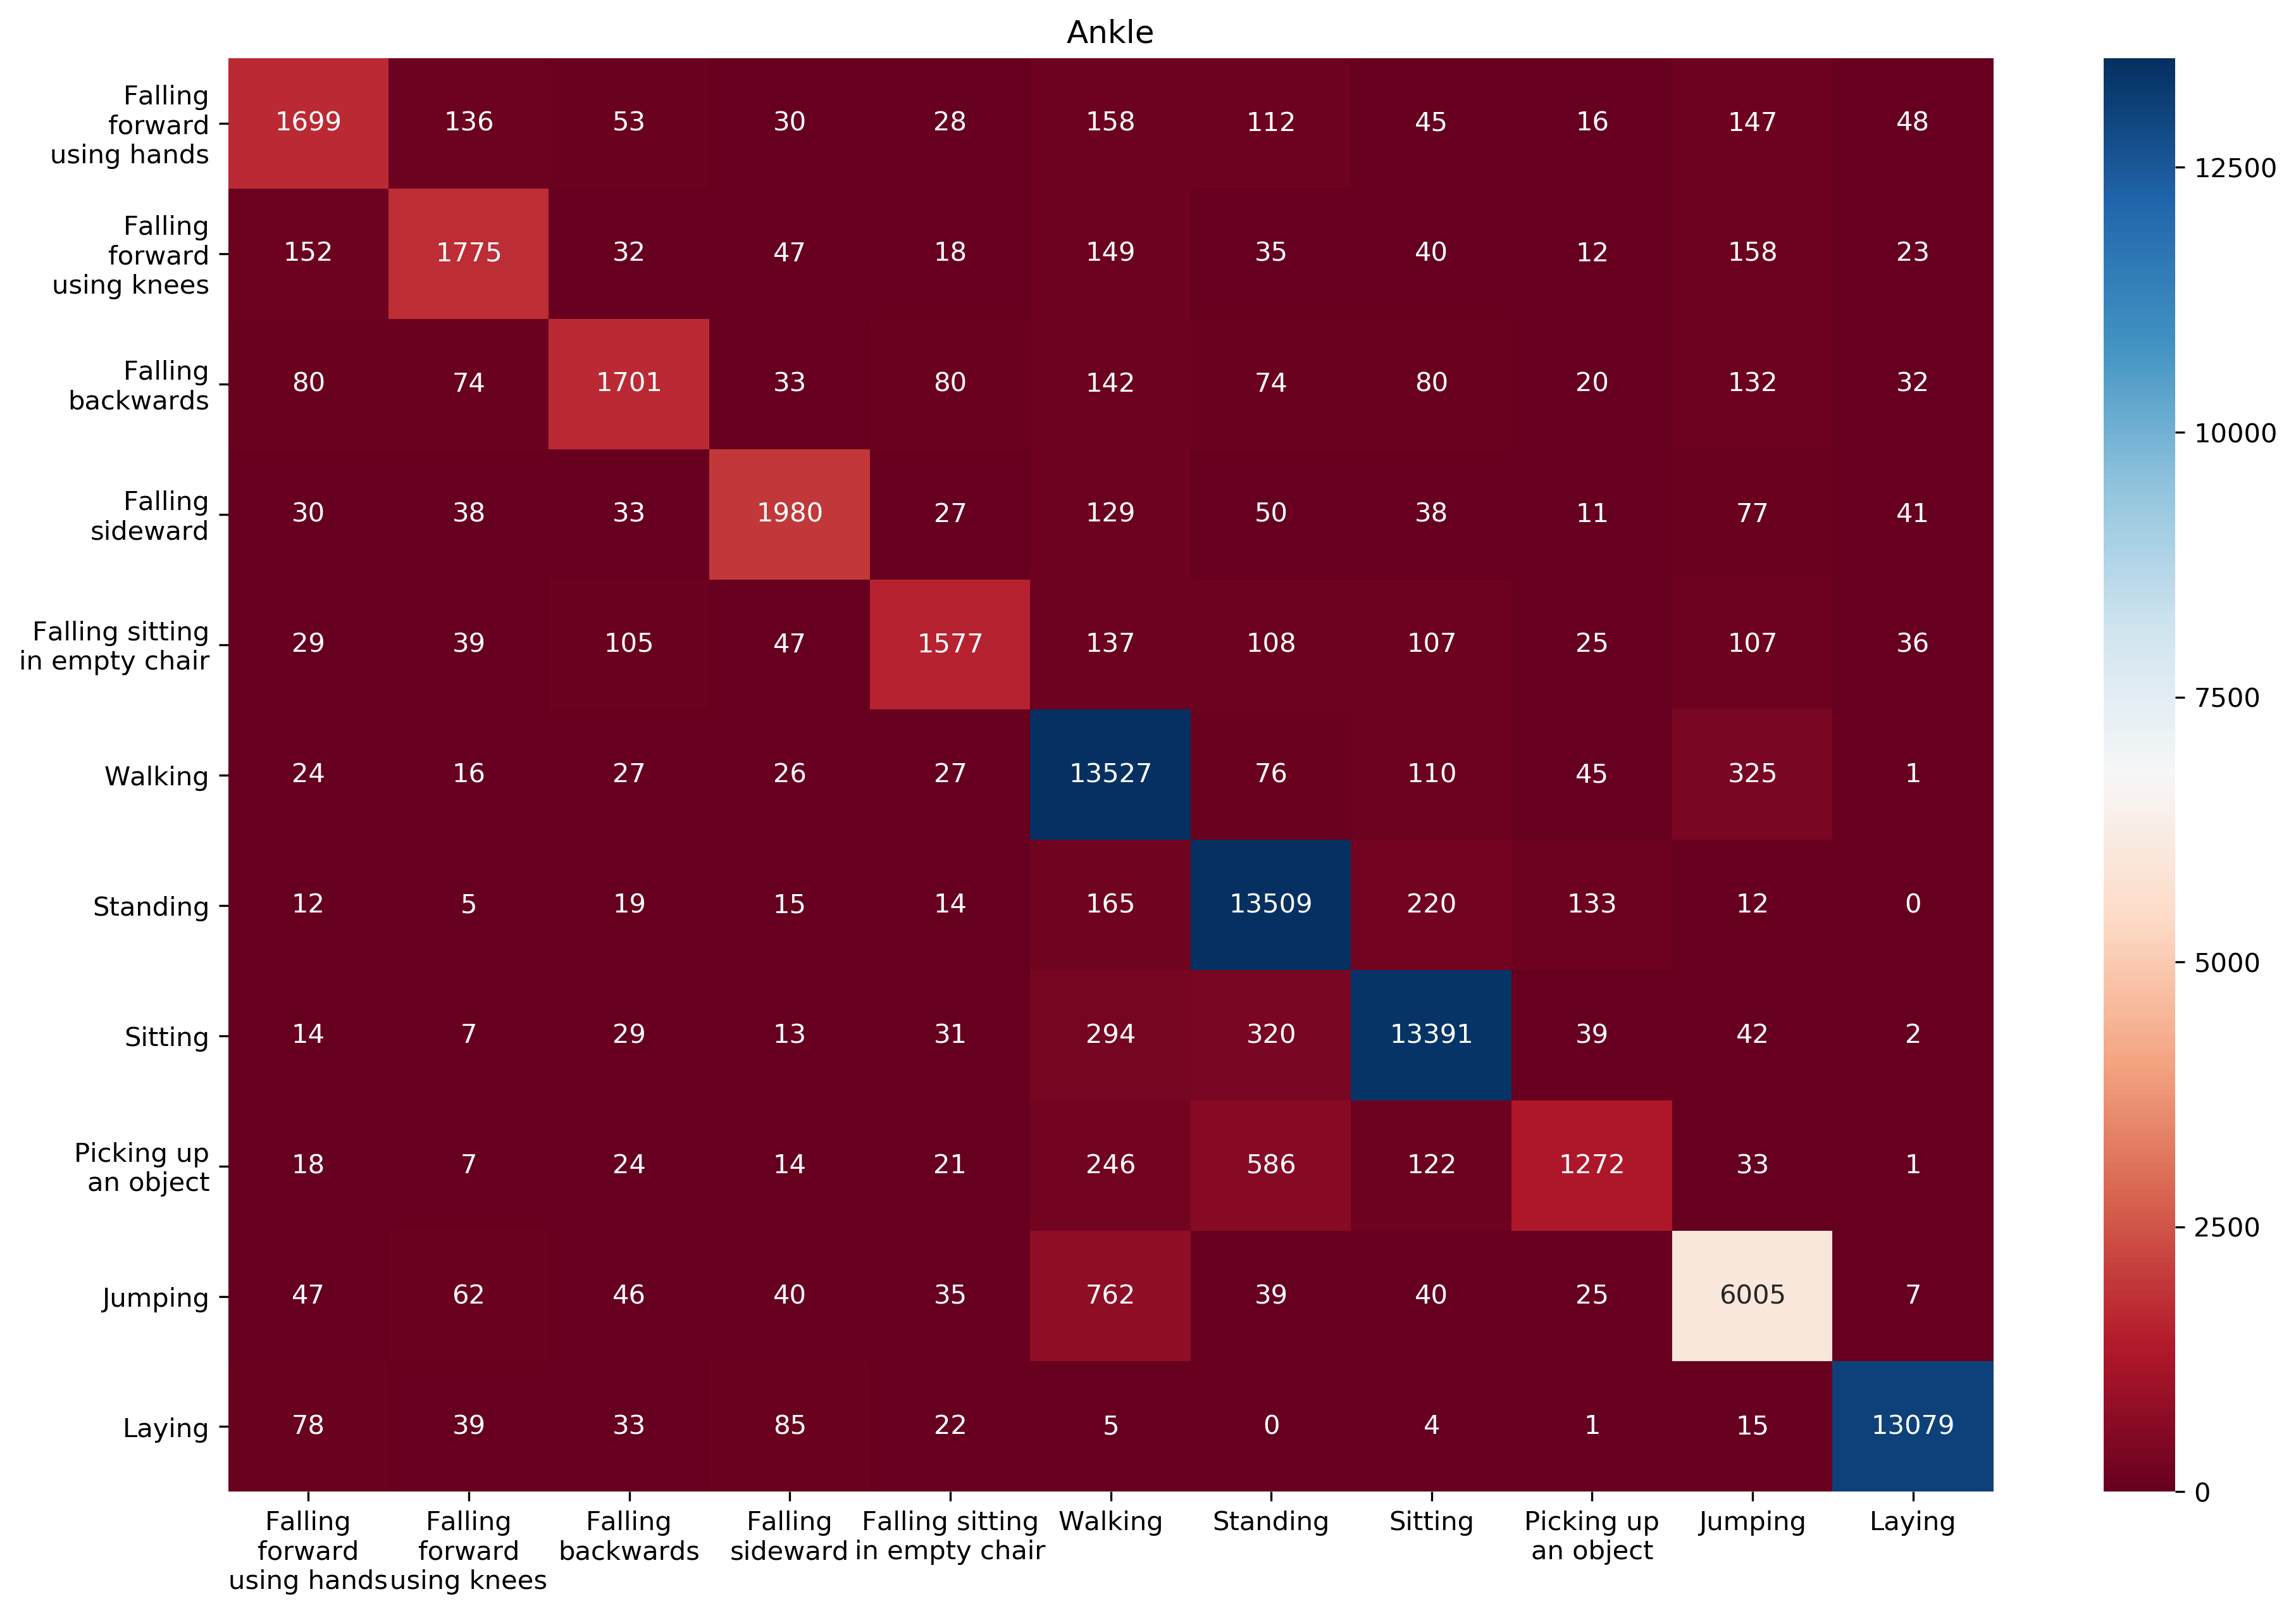

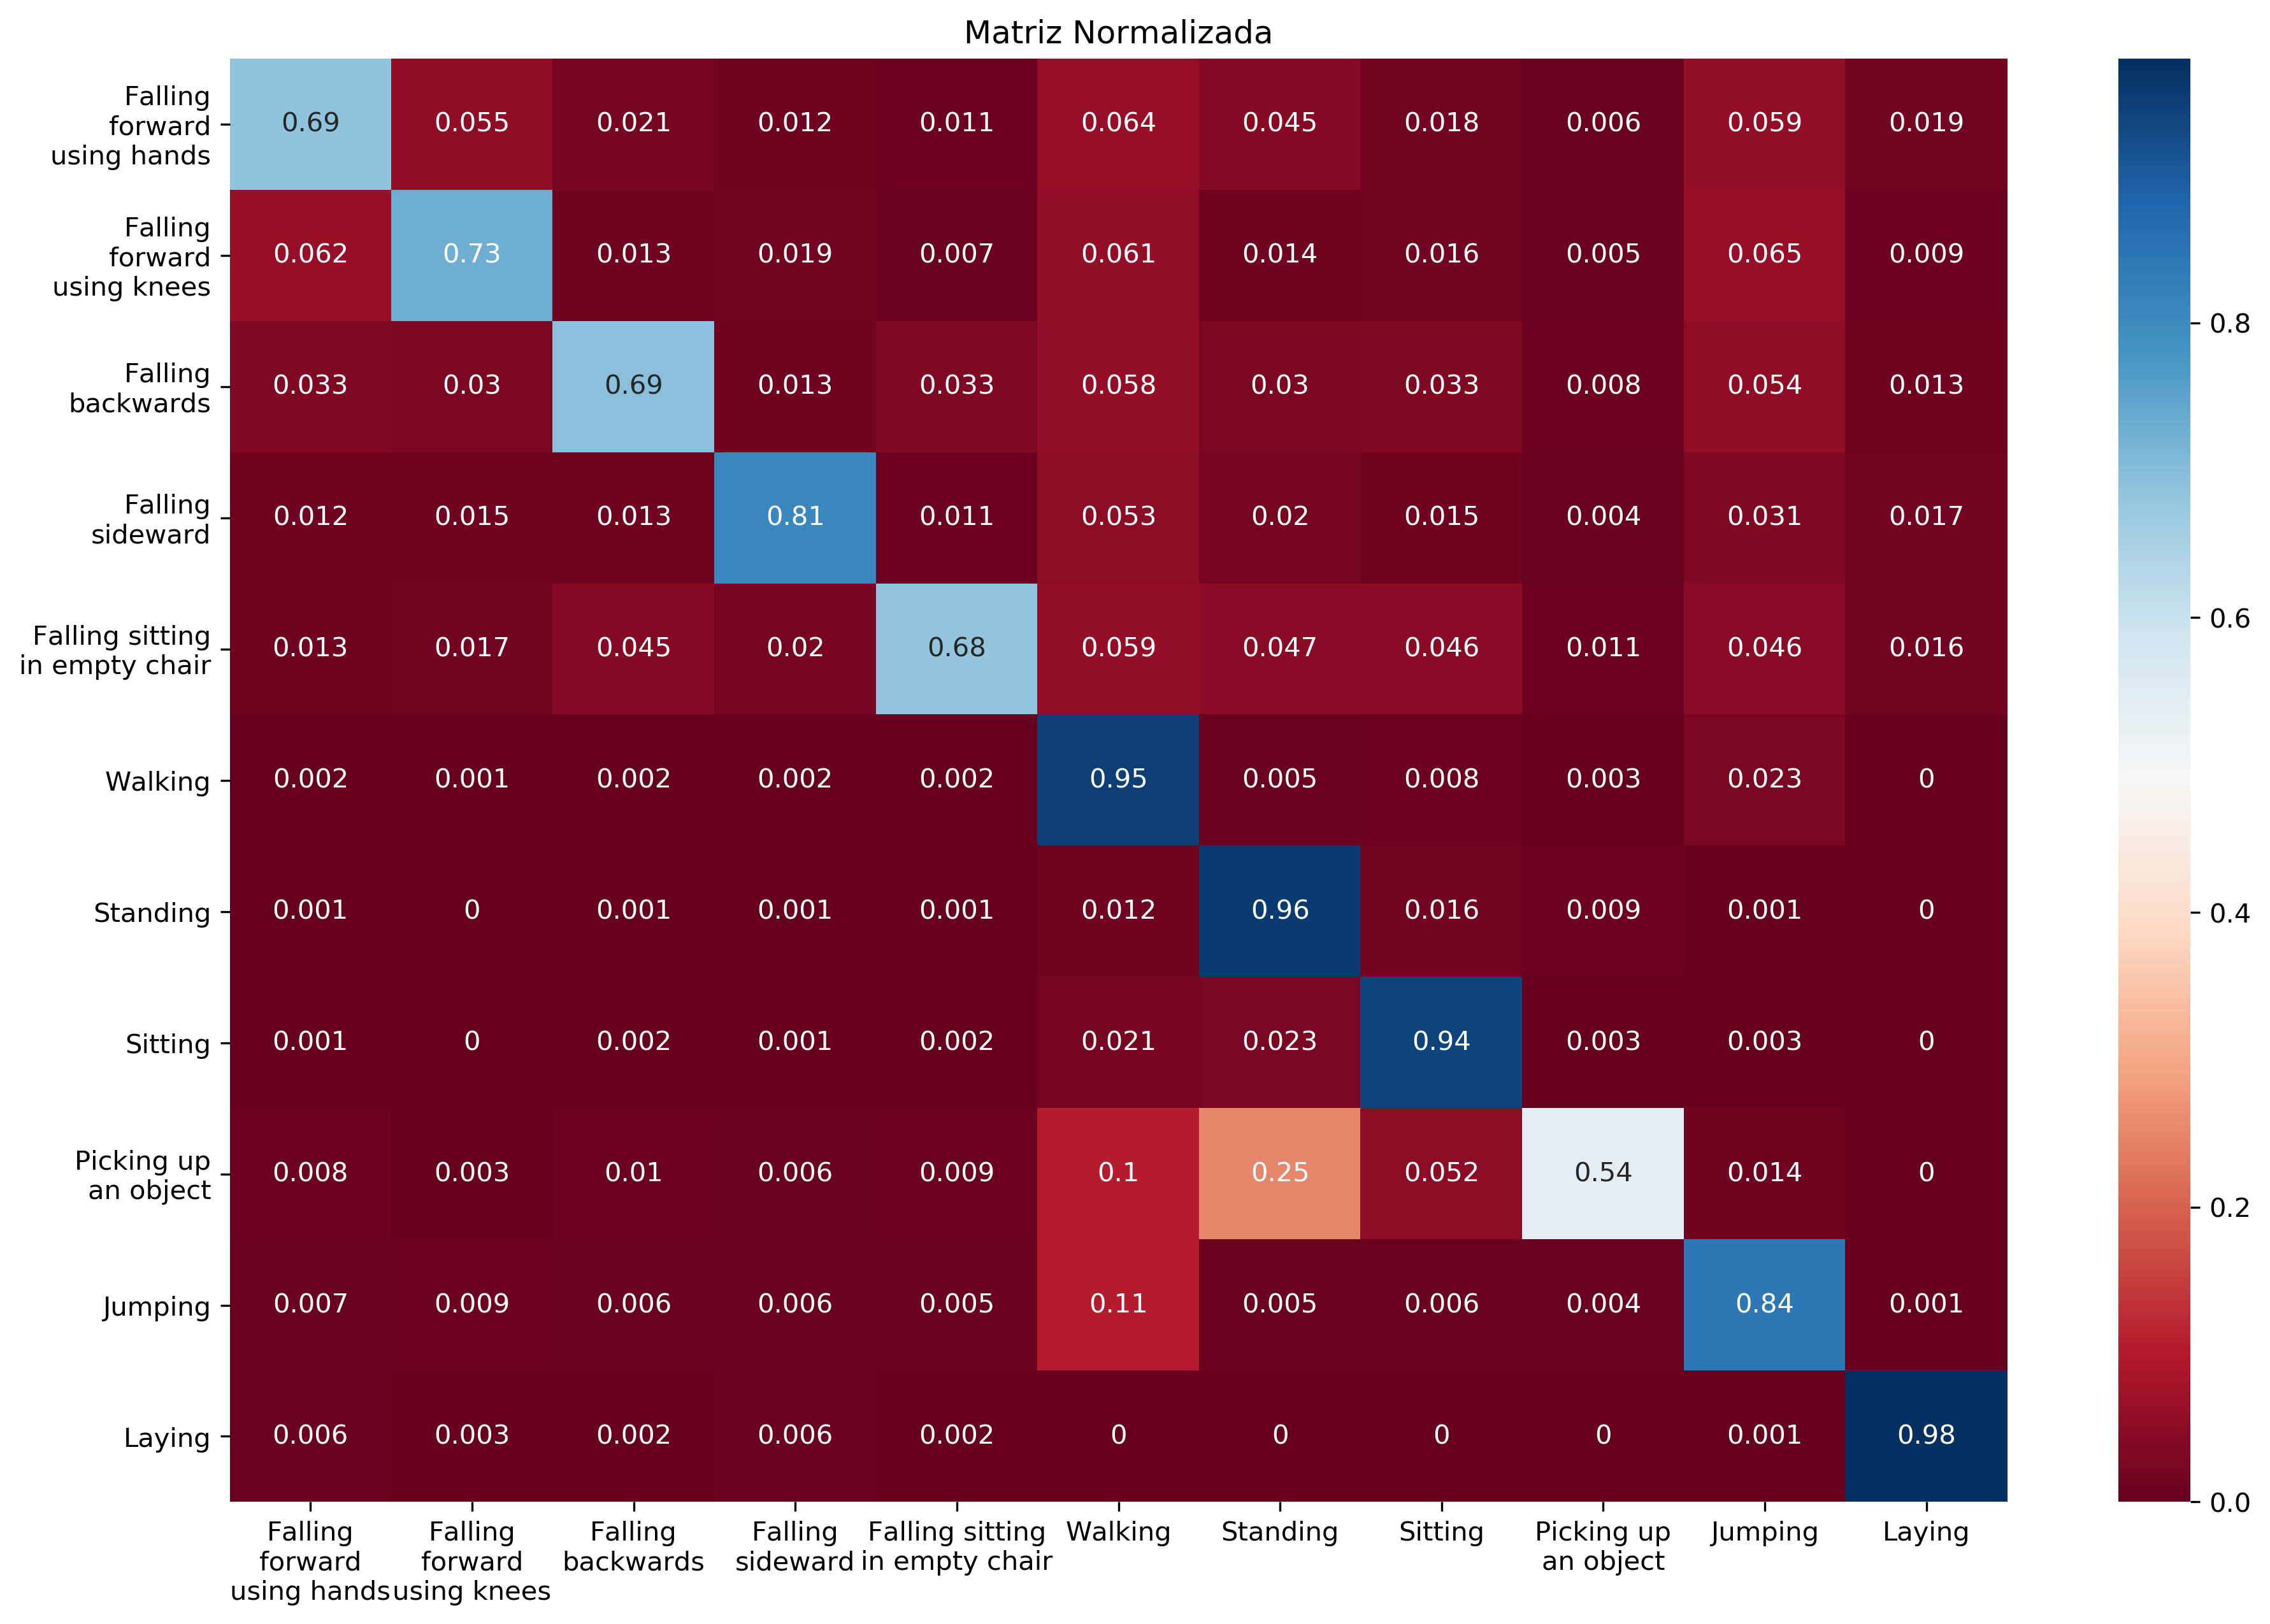

KeyboardInterrupt: 

In [21]:


clf = RandomForestClassifier(n_estimators=10, min_samples_split=2, min_samples_leaf=1, bootstrap=True)
                                

# use a full grid over all parameters
param_grid = {"min_samples_split": [2],
              "bootstrap": [True],
             "n_estimators": [10]}

# # run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, iid=False, n_jobs=4)

for sensor in sensors:
    
    X_train, X_test, y_train, y_test = train_test_split(sensors[sensor], activity, test_size=0.3, random_state=42)

    start = time()
    grid_search.fit(X_train, y_train)

    print("GridSearchCV for %s data using Random Forest took %.2f seconds for %d candidate parameter settings."
          % (sensor, time() - start, len(grid_search.cv_results_['params'])))
    report(grid_search.cv_results_)

    y_pred = grid_search.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    print("Acuracia:", accuracy)
    
    print("Random Forest clf_report (output_dict=False)")
    
    clf_report = classification_report(y_test, y_pred, output_dict=False, target_names=[a.replace("\n", " ") for a in atividades])
    
    print(clf_report)
    
#     print("Random Forest clf_report (output_dict=True)")
    clf_report = classification_report(y_test, y_pred, output_dict=True, target_names=[a.replace("\n", " ") for a in atividades])
    
#     print(clf_report)

    clf_report = pd.DataFrame(data=clf_report).drop("support", axis=0).transpose()
    clf_report.to_csv(sensor + "_classification_report_rf.csv")

    cm = confusion_matrix(y_test, y_pred)
#     pd.DataFrame(data=cm, index=atividades, columns=atividades).to_csv(sensor + "_cm_rf.csv")
    
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
#     pd.DataFrame(data=cm_norm, index=atividades, columns=atividades).to_csv(sensor + "_cm_rf.csv")

    print(cm)

    
    plt.figure(dpi=300, figsize=(15, 10))
    plt.title(sensor)
    sns.heatmap(cm, xticklabels=atividades, yticklabels=atividades, cmap="RdBu", annot=True, fmt='d')
    plt.xticks(rotation=0)
    plt.savefig(sensor + "_matriz_confusao_rf.png", dpi=300)
    plt.show()
    
    plt.figure(dpi=300, figsize=(15, 10))
    plt.title("Matriz Normalizada")
    sns.heatmap(cm_norm.round(3), xticklabels=atividades, yticklabels=atividades, cmap="RdBu", annot=True)
    plt.xticks(rotation=0)
#     plt.savefig(sensor + "_matriz_confusao_norm_rf.png", dpi=300)
    plt.show()

    

# Treinamento utilizando o XGBoost
* Utiliza cross-validation
* 30% dos dados são usados para teste e 70% para o treinamento

In [ ]:
clf = xgb.XGBClassifier()

# use a full grid over all parameters
param_grid = {'max_depth': [6, 10]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, iid=False, n_jobs=4)

for sensor in sensors:
    
    X_train, X_test, y_train, y_test = train_test_split(sensors[sensor], activity, test_size=0.3, random_state=42)

    start = time()
    grid_search.fit(X_train, y_train)

    print("GridSearchCV for %s data using XGBOOST took %.2f seconds for %d candidate parameter settings."
          % (sensor, time() - start, len(grid_search.cv_results_['params'])))
    report(grid_search.cv_results_)

    y_pred = grid_search.predict(X_test)


    accuracy = accuracy_score(y_test, y_pred)

    print("Acuracia:", accuracy)
    
    print("XGBOOST clf_report (output_dict=False)")
    
    clf_report = classification_report(y_test, y_pred, output_dict=False, target_names=[a.replace("\n", " ") for a in atividades])
    
    print(clf_report)
    
#     print("XGBOOST clf_report (output_dict=True)")
    clf_report = classification_report(y_test, y_pred, output_dict=True, target_names=[a.replace("\n", " ") for a in atividades])
    
#     print(clf_report)

    clf_report = pd.DataFrame(data=clf_report).drop("support", axis=0).transpose()
    clf_report.to_csv(sensor + "_classification_report_xgb.csv")

    cm = confusion_matrix(y_test, y_pred)
    pd.DataFrame(data=cm, index=atividades, columns=atividades).to_csv(sensor + "_cm_xgb.csv")
    
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    pd.DataFrame(data=cm_norm, index=atividades, columns=atividades).to_csv(sensor + "_cm_xgb.csv")

    print(cm)

    
    plt.figure(dpi=300, figsize=(15, 10))
    plt.title(sensor)
    sns.heatmap(cm, xticklabels=atividades, yticklabels=atividades, cmap="RdBu", annot=True, fmt='d')
    plt.xticks(rotation=0)
    plt.savefig(sensor + "_matriz_confusao_xgb.png", dpi=300)
    plt.show()
    
    plt.figure(dpi=300, figsize=(15, 10))
    plt.title("Matriz Normalizada")
    sns.heatmap(cm_norm.round(3), xticklabels=atividades, yticklabels=atividades, cmap="RdBu", annot=True)
    plt.xticks(rotation=0)
#     plt.savefig(sensor + "_matriz_confusao_norm_xgb.png", dpi=300)
    plt.show()
